<a href="https://colab.research.google.com/github/Masterjun12/Generative_model/blob/main/GAN-and-elastic-deformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MNIST data 불러오기(Test data를 사용하기 위함)

In [24]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import numpy as np

(_, _), (test_images, test_labels) = mnist.load_data()

test_images = np.reshape(test_images, (-1,784))

In [25]:
import numpy as np
import cv2
import random
from scipy.ndimage import gaussian_filter, map_coordinates

### 엘라스틱 디포메이션

In [26]:
def elastic_deformation(image, alpha, sigma):
    random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    distorted_image = map_coordinates(image.reshape(shape), indices, order=1, mode='reflect')
    return distorted_image.reshape(shape)

def generate_augmented_data(images, labels, num_images_per_label=100, alpha=50, sigma=5):
    augmented_images = []
    augmented_labels = []

    for label in np.unique(labels):
        label_indices = np.where(labels == label)[0]
        selected_indices = np.random.choice(label_indices, min(num_images_per_label, len(label_indices)), replace=False)

        for idx in selected_indices:
            image = images[idx].reshape(28, 28)  # Reshape to 28x28
            augmented_image = elastic_deformation(image, alpha, sigma)
            augmented_images.append(augmented_image.flatten())  # Flatten back to (784,)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)


### 학습할 data 불러오기

In [28]:
alpha_list = [40, 50, 60, 70]

# Load extracted_train_images and extracted_train_labels
extracted_train_images = np.load('extracted_train_images.npy')
extracted_train_labels = np.load('extracted_train_labels.npy')

all_augmented_images = []
all_augmented_labels = []

for i in range(1, 4):
    for alpha in alpha_list:
        # Generate augmented data
        augmented_images, augmented_labels = generate_augmented_data(extracted_train_images, extracted_train_labels, alpha=alpha)

        all_augmented_images.append(augmented_images)
        all_augmented_labels.append(augmented_labels)

        print("Augmented images and labels for iteration", i, "with alpha", alpha, "have been generated.")

# Concatenate original and augmented data
new_train_images = np.concatenate((extracted_train_images, *all_augmented_images), axis=0)
new_train_labels = np.concatenate((extracted_train_labels, *all_augmented_labels), axis=0)

# Save new datasets
np.save('new_train_images.npy', new_train_images)
np.save('new_train_labels.npy', new_train_labels)

print("Shape of new_train_images:", new_train_images.shape)
print("Shape of new_train_labels:", new_train_labels.shape)


Augmented images and labels for iteration 1 with alpha 40 have been generated.
Augmented images and labels for iteration 1 with alpha 50 have been generated.
Augmented images and labels for iteration 1 with alpha 60 have been generated.
Augmented images and labels for iteration 1 with alpha 70 have been generated.
Augmented images and labels for iteration 2 with alpha 40 have been generated.
Augmented images and labels for iteration 2 with alpha 50 have been generated.
Augmented images and labels for iteration 2 with alpha 60 have been generated.
Augmented images and labels for iteration 2 with alpha 70 have been generated.
Augmented images and labels for iteration 3 with alpha 40 have been generated.
Augmented images and labels for iteration 3 with alpha 50 have been generated.
Augmented images and labels for iteration 3 with alpha 60 have been generated.
Augmented images and labels for iteration 3 with alpha 70 have been generated.
Shape of new_train_images: (13000, 784)
Shape of new

### 기존 이미지셋 확인

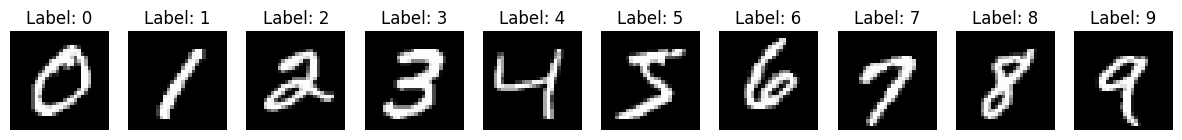

In [6]:
import matplotlib.pyplot as plt

# Function to plot one image per label
def plot_images_per_label(images, labels):
    unique_labels = np.unique(labels)
    fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 3))

    for i, label in enumerate(unique_labels):
        # Find the index of the first image with the current label
        index = np.where(labels == label)[0][0]
        # Plot the image
        axes[i].imshow(images[index].reshape(28, 28), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

# Plot one image per label
plot_images_per_label(extracted_train_images, extracted_train_labels)


### 엘라스틱 디포메이션된 이미지셋 확인

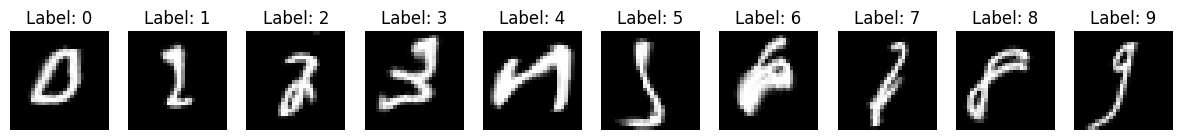

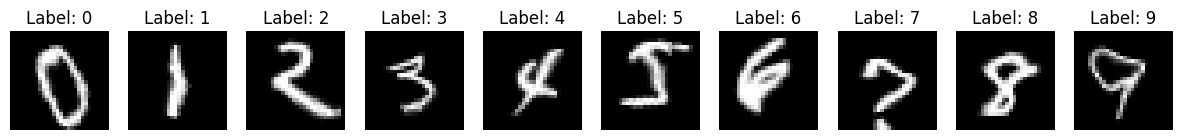

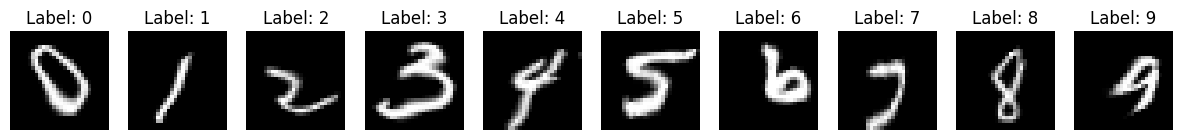

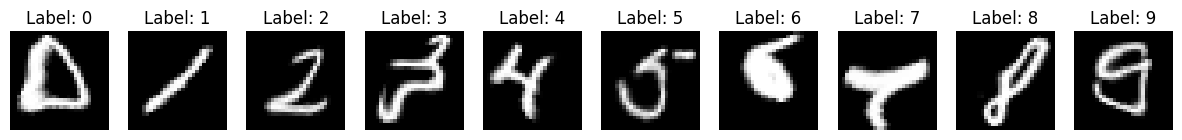

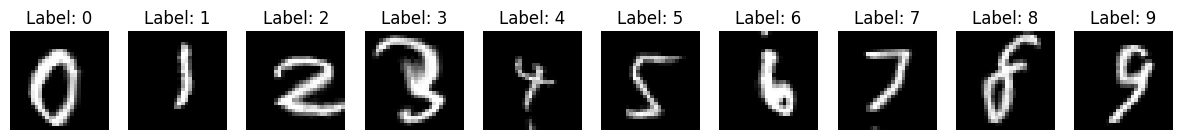

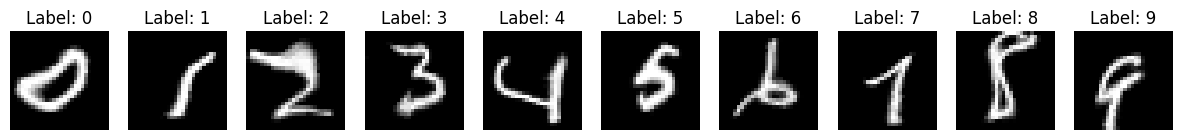

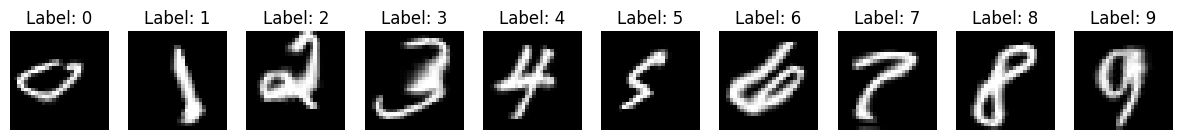

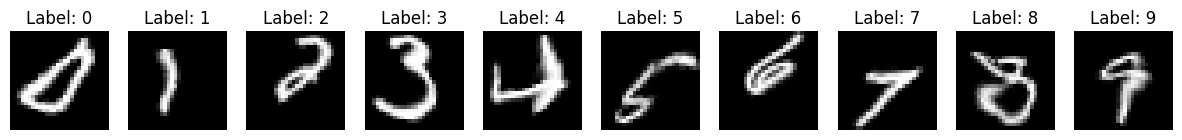

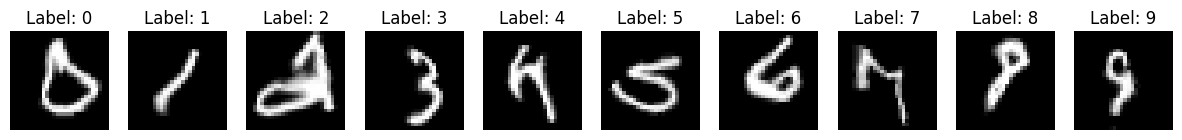

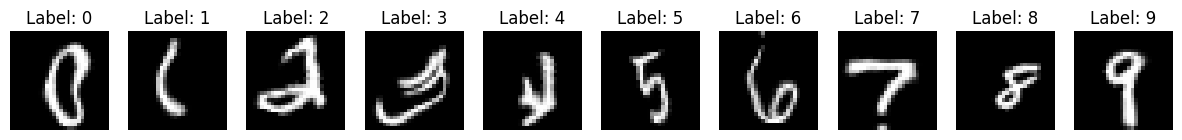

In [11]:
def plot_images_per_label(images, labels):
    unique_labels = np.unique(labels)
    fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 3))

    for i, label in enumerate(unique_labels):
        # Find the index of the first image with the current label
        index = np.where(labels == label)[0][0]
        # Plot the image
        axes[i].imshow(images[index].reshape(28, 28), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

# Define a range of alpha values
alpha_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Generate augmented images for each alpha value
for sigma in alpha_values:
    augmented_images, augmented_labels = generate_augmented_data(extracted_train_images, extracted_train_labels, alpha=alpha)
    plot_images_per_label(augmented_images, augmented_labels)

### GAN model

In [32]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Input
from keras.optimizers import Adam

# Load data
new_train_images = np.load('new_train_images.npy')
new_train_labels = np.load('new_train_labels.npy')
new_train_images = new_train_images.reshape(-1, 28, 28, 1)


# Reshape
new_train_images = new_train_images.reshape(-1, 28, 28, 1)

# generator model
def build_generator(latent_dim):
    generator = Sequential()
    generator.add(Dense(7 * 7 * 64, input_dim=latent_dim))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Reshape((7, 7, 64)))
    generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return generator

# discriminator model
def build_discriminator(input_shape):
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=input_shape))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    return discriminator

# GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return gan

# hyperparameters
latent_dim = 100
image_shape = new_train_images.shape[1:]
generator = build_generator(latent_dim)
discriminator = build_discriminator(image_shape)
gan = build_gan(generator, discriminator)

# Generate random latent
latent_vectors = np.random.normal(size=(len(new_train_images), latent_dim))

# Train
gan.fit(latent_vectors, np.ones(len(new_train_images)), epochs=100, batch_size=32)

# Save
generator.save_weights('generator_weights.h5')


Epoch 1/100
407/407 [==============================] - 5s 10ms/step - loss: 0.5385
Epoch 2/100
407/407 [==============================] - 4s 10ms/step - loss: 0.4897
Epoch 3/100
407/407 [==============================] - 4s 10ms/step - loss: 0.4859
Epoch 4/100
407/407 [==============================] - 4s 9ms/step - loss: 0.4845
Epoch 5/100
407/407 [==============================] - 4s 10ms/step - loss: 0.4828
Epoch 6/100
407/407 [==============================] - 4s 10ms/step - loss: 0.4728
Epoch 7/100
407/407 [==============================] - 4s 10ms/step - loss: 0.4642
Epoch 8/100
407/407 [==============================] - 4s 10ms/step - loss: 0.4614
Epoch 9/100
407/407 [==============================] - 4s 10ms/step - loss: 0.4567
Epoch 10/100
407/407 [==============================] - 4s 10ms/step - loss: 0.4531
Epoch 11/100
407/407 [==============================] - 4s 10ms/step - loss: 0.4514
Epoch 12/100
407/407 [==============================] - 4s 10ms/step - loss: 0.4488
Ep

407/407 [==============================] - 4s 10ms/step - loss: 0.3495
Epoch 99/100
407/407 [==============================] - 4s 10ms/step - loss: 0.3494
Epoch 100/100
407/407 [==============================] - 4s 10ms/step - loss: 0.3494


### 데이터 Generate

In [66]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU
from keras.optimizers import Adam

# Load data
existing_train_images = np.load('new_train_images.npy')
existing_train_labels = np.load('new_train_labels.npy')

# generator model
latent_dim = 100
generator = build_generator(latent_dim)
generator.load_weights('generator_weights.h5')

# Generate
num_generated_images = 5000
latent_vectors = np.random.normal(size=(num_generated_images, latent_dim))
generated_images = generator.predict(latent_vectors)

# Reshape generated images
generated_images = generated_images.reshape(-1, 28*28)

# Combine generated images
combined_images = np.concatenate((existing_train_images, generated_images), axis=0)
combined_labels = np.concatenate((existing_train_labels, np.ones(num_generated_images)), axis=0)

# Save
np.save('new_train_images.npy', combined_images)
np.save('new_train_labels.npy', combined_labels)

print("Combined data has been saved to new npy files.")

157/157 [==============================] - 1s 4ms/step
Combined data has been saved to new npy files.


In [68]:
print(combined_images.shape)
print(combined_labels.shape)

(48000, 784)
(48000,)


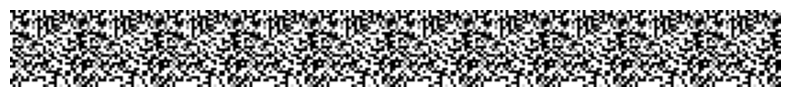

In [69]:
# Display the first 10 images, combined into one row
num_images_to_show = 10  # Show the first 10 images
image_width = 28  # Image width

# Assuming generated_images is in the shape (num_images, 28*28), reshape to (28, 28)
generated_images = generated_images.reshape(-1, image_width, image_width)

# Concatenate the images horizontally to create one long image
combined_image = np.concatenate(generated_images[:num_images_to_show], axis=1)

# Display the result
plt.figure(figsize=(10, 1))  # Adjust the figure size
plt.imshow(combined_image, cmap='gray')  # Show the combined horizontal image
plt.axis('off')  # Hide the axes
plt.show()


### 평가 모델

In [58]:
# define model
model = tf.keras.Sequential([
    Input(shape=(784,)),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

# compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
# model fit
model.fit(combined_images, combined_labels, epochs=10, batch_size=32, verbose=2)

# eval model
test_images = test_images.reshape(-1, 784).astype('float32') / 255.0
test_labels = test_labels.astype('int')  # label to int

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"\n테스트 정확도: {test_acc}")

Epoch 1/10
1344/1344 - 7s - loss: 0.0038 - accuracy: 0.9989 - 7s/epoch - 5ms/step
Epoch 2/10
1344/1344 - 7s - loss: 0.0055 - accuracy: 0.9982 - 7s/epoch - 5ms/step
Epoch 3/10
1344/1344 - 7s - loss: 0.0046 - accuracy: 0.9986 - 7s/epoch - 5ms/step
Epoch 4/10
1344/1344 - 7s - loss: 0.0012 - accuracy: 0.9999 - 7s/epoch - 5ms/step
Epoch 5/10
1344/1344 - 7s - loss: 0.0075 - accuracy: 0.9975 - 7s/epoch - 5ms/step
Epoch 6/10
1344/1344 - 7s - loss: 0.0028 - accuracy: 0.9993 - 7s/epoch - 5ms/step
Epoch 7/10
1344/1344 - 7s - loss: 0.0026 - accuracy: 0.9993 - 7s/epoch - 5ms/step
Epoch 8/10
1344/1344 - 7s - loss: 0.0061 - accuracy: 0.9980 - 7s/epoch - 5ms/step
Epoch 9/10
1344/1344 - 7s - loss: 0.0042 - accuracy: 0.9990 - 7s/epoch - 5ms/step
Epoch 10/10
1344/1344 - 7s - loss: 0.0026 - accuracy: 0.9992 - 7s/epoch - 5ms/step
313/313 - 1s - loss: 4.4652 - accuracy: 0.0892 - 1s/epoch - 4ms/step

테스트 정확도: 0.08919999748468399
